In [1]:
# Import different kinds of libraries
import os
import cv2
import glob
import keras
import numpy as np
import seaborn as sns
import datetime as dt
import tensorflow as tf
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from keras import Model, layers
from IPython.display import Image
import matplotlib.font_manager as fm
from tensorflow.keras import callbacks,optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.models import load_model, model_from_json, Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet121, ResNet50, DenseNet201, InceptionV3, Xception, MobileNetV2, VGG19, VGG16
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Concatenate, Dropout,GlobalAveragePooling2D

2024-06-28 13:25:34.293117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 13:25:34.293254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 13:25:34.442832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#path for bangla font
font_path = '/kaggle/input/d/ayshaaktersumi/bangla-font/NotoSansBengalit.ttf'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#global height width
height = 256
width = 256
def load_data(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        print(label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            # Error handling
            try:
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Error: Unable to read image '{image_path}'")
                    continue
                image = cv2.resize(image, (height, width))  # Resize image
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = image / 255.0
                images.append(image)
                labels.append(label)
            except Exception as e:
                print(f"Error processing image '{image_path}': {e}")
    return np.array(images), np.array(labels)

# Load data
X, y = load_data('/content/drive/MyDrive/FL23D092/Sign Language Images/Bangla_Sign_Final_datasetV2')

# **background remove**

In [ ]:
!pip install removebg
!pip install rembg

In [ ]:
from rembg import new_session, remove
model_name = "u2net"
rembg_session = new_session(model_name)

In [ ]:
import os
def list_files(folder_path):
    file_paths = []
    # Walk through all the directories and subdirectories
    for root, directories, files in os.walk(folder_path):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

In [ ]:
img_list = list_files('/content/drive/MyDrive/FL23D092/Sign Language Images/Bangla_Sign_Final_datasetV2')
img_list

In [ ]:
def get_bg_removed(img):
  output = remove(
    img,
    session=rembg_session,
    alpha_matting=True,
    alpha_matting_foreground_threshold=270,
    alpha_matting_background_threshold=20,
    alpha_matting_erode_size=11,
  )
  return output;

In [ ]:
import matplotlib.pyplot as plt

def print_img(img_path, format='jpg'):
  img = plt.imread(img_path, format=format)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [ ]:
from PIL import Image

In [ ]:
base_folder = '/content/drive/MyDrive/FL23D092/Sign Language Images/Bangla_Sign_Final_datasetV2/'
sub_folder = 'Bg_remove/'
extension = 'png'

def gen_bg_removed(img_path):

  file_name = os.path.basename(img_path)
  sub_path = img_path.removeprefix(base_folder).removesuffix(file_name)

  output_path = base_folder + sub_folder + sub_path

  if not os.path.exists(output_path):
    os.makedirs(output_path)

  with open(img_path, 'rb') as i:
      with open(output_path + file_name, 'wb') as o:
          input = i.read()
          output = get_bg_removed(input)
          o.write(output)

In [ ]:
for img_path in img_list:
  gen_bg_removed(img_path)

In [ ]:
root_dir = '/content/drive/MyDrive/FL23D092/Sign Language Images/Bangla_Sign_Final_datasetV2/Bg_remove'
# Count the number of images
def count_total(directory):
    num_images = 0
    for f in os.listdir(directory):
        f_path = os.path.join(directory, f)
        # check if the subdirectory or file exists and is a directory
        if os.path.isdir(f_path):
            num_images += count_total(f_path)
        elif os.path.splitext(f)[1].lower() in image_extensions:
            num_images += 1
    return num_images
# function call
num_images = count_total(root_dir)
print(f'Total number of images: {num_images}')

## **Resize, Grayscale, Increase contrast**

In [ ]:
#Gamma < 1: Darkens the image, reducing the contrast
#Gamma = 1: No change, the image remains unchanged.
#Gamma > 1: Lightens the image, increasing the contrast
def gamma_correction(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255.0 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)
# specify the desired size for resizing
desired_size = (256, 256)

# specify the root directory
root_dir = '/content/drive/MyDrive/FL23D092/Sign Language Images/Bangla_Sign_Final_datasetV2/Bg_remove'

# specify the directory to save processed images
save_dir = '/content/drive/MyDrive/FL23D092/Sign Language Images/Bangla_Sign_Final_datasetV2/augmented_data/'

# list of image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

# iterate over all subdirectories in the root directory
for subdir in os.listdir(root_dir):
    sub_dir_path = os.path.join(root_dir, subdir)
    if os.path.isdir(sub_dir_path):
        for filename in os.listdir(sub_dir_path):
            file_path = os.path.join(sub_dir_path, filename)
            if os.path.splitext(file_path)[1].lower() in image_extensions:
                img = cv2.imread(file_path)
                if img is not None:
                    # resize the image
                    resized_img = cv2.resize(img, desired_size)
                    # convert the image to grayscale
                    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
                    # enhance contrast using histogram equalization
                    enhanced_img = cv2.equalizeHist(gray_img)
                    # apply gamma correction
                    gamma_corrected_img = gamma_correction(enhanced_img, gamma=1.5)
                    # construct the save path for the processed image
                    save_path = os.path.join(save_dir, subdir, filename)
                    os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create directory if it doesn't exist
                    # save the preprocessed image
                    cv2.imwrite(save_path, gamma_corrected_img)

# **Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_images(folder_path, num_of_augment):
    # Define the augmentation parameters
    img_gen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )

    # Loop through all files in the folder path
    for root, _, filenames in os.walk(folder_path):
        for filename in filenames:
            if filename.endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(root, filename)

                # Load the original image
                original_img = load_img(img_path, target_size=(250, 250))
                original_img_array = img_to_array(original_img)
                original_img_array = original_img_array.reshape((1,) + original_img_array.shape)

                # Perform augmentation and save the augmented images
                save_to_dir = os.path.dirname(img_path)  # Save in the same subfolder as the original image
                save_prefix = filename.split('.')[0]  # Use the original filename as prefix

                # Generate a batch of augmented images from the single image
                augmented_images = img_gen.flow(original_img_array, batch_size=num_of_augment,
                                                 save_to_dir=save_to_dir, save_prefix=save_prefix,
                                                 save_format='jpeg')

                # Iterate through the generated batch and save each image
                for i in range(num_of_augment):
                    augmented_images.next()

# Call the function with the desired folder path
augment_images('/content/drive/MyDrive/FL23D092/Sign Language Images/Bangla_Sign_Final_datasetV2/augmented_data', 5)

> **Count Images**

In [3]:
# count the images of each subdirectory
root_dir = '/kaggle/input/d/ayshaaktersumi/augmented-data/Augmented_data'

# specify the image file extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

# iterate over all subdirectories in the root directory
for sub_dir in os.listdir(root_dir):
    sub_dir_path = os.path.join(root_dir, sub_dir) # construct the full path to the subdirectory

    # check if the subdirectory exists and is a directory
    if os.path.isdir(sub_dir_path):
        # count the number of image files in the subdirectory
        num_images = sum(1 for f in os.listdir(sub_dir_path) if os.path.splitext(f)[1].lower() in image_extensions)
        # print the subdirectory name and the number of images
        print(f'{sub_dir}: {num_images} images')

ত: 222 images
হ: 318 images
ঃ: 252 images
০: 252 images
ক: 222 images
আ: 276 images
চ: 204 images
ড: 216 images
ব: 270 images
ভ: 246 images
ঢ: 216 images
ড়: 228 images
ফ: 258 images
ং: 258 images
ট: 306 images
গ: 264 images
ম: 240 images
স: 306 images
৮: 252 images
ই: 294 images
ল: 288 images
জ: 276 images
ছ: 192 images
ন: 228 images
উ: 276 images
খ: 126 images
ধ: 192 images
থ: 234 images
২: 276 images
ও: 222 images
৫: 270 images
র: 180 images
এ: 240 images
অ: 342 images
য়: 186 images
ঠ: 264 images
ঘ: 204 images
১: 276 images
দ: 264 images
ঝ: 276 images
৩: 276 images
প: 198 images
৭: 251 images
৪: 270 images
৬: 276 images
৯: 240 images


In [4]:
# Count the number of images

def count_total(directory):
    num_images = 0
    for f in os.listdir(directory):
        f_path = os.path.join(directory, f)
        # check if the subdirectory or file exists and is a directory
        if os.path.isdir(f_path):
            num_images += count_total(f_path)
        elif os.path.splitext(f)[1].lower() in image_extensions:
            num_images += 1
    return num_images
# function call
num_images = count_total(root_dir)
print(f'Total number of images: {num_images}')

Total number of images: 11423


**Check classes**

In [5]:
#Load the dataset the JPES files what we converted before
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    root_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 11423 files belonging to 46 classes.


In [6]:
#Class name in my dataset
class_name=dataset.class_names
class_name

['ং',
 'ঃ',
 'অ',
 'আ',
 'ই',
 'উ',
 'এ',
 'ও',
 'ক',
 'খ',
 'গ',
 'ঘ',
 'চ',
 'ছ',
 'জ',
 'ঝ',
 'ট',
 'ঠ',
 'ড',
 'ড়',
 'ঢ',
 'ত',
 'থ',
 'দ',
 'ধ',
 'ন',
 'প',
 'ফ',
 'ব',
 'ভ',
 'ম',
 'য়',
 'র',
 'ল',
 'স',
 'হ',
 '০',
 '১',
 '২',
 '৩',
 '৪',
 '৫',
 '৬',
 '৭',
 '৮',
 '৯']

In [7]:
#image shape
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[28  7 17 18 18 25 11 29 41 44  1 44 40  7  7 19 33  6 14 24 34  0  7  5
  4 12 44 29 25 21 24 30]


**Train Test**

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=50):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
train_size = 0
for _ in train_ds:
    train_size += 1

val_size = 0
for _ in val_ds:
    val_size += 1

test_size = 0
for _ in test_ds:
    test_size += 1

print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

Training set size: 249
Validation set size: 71
Test set size: 37


In [12]:
BATCH_SIZE = 32  # Adjust batch size as needed
EPOCHS = 50  # Adjust number of epochs as needed
LEARNING_RATE = 0.001  # Adjust learning rate as needed

**Showing random data**

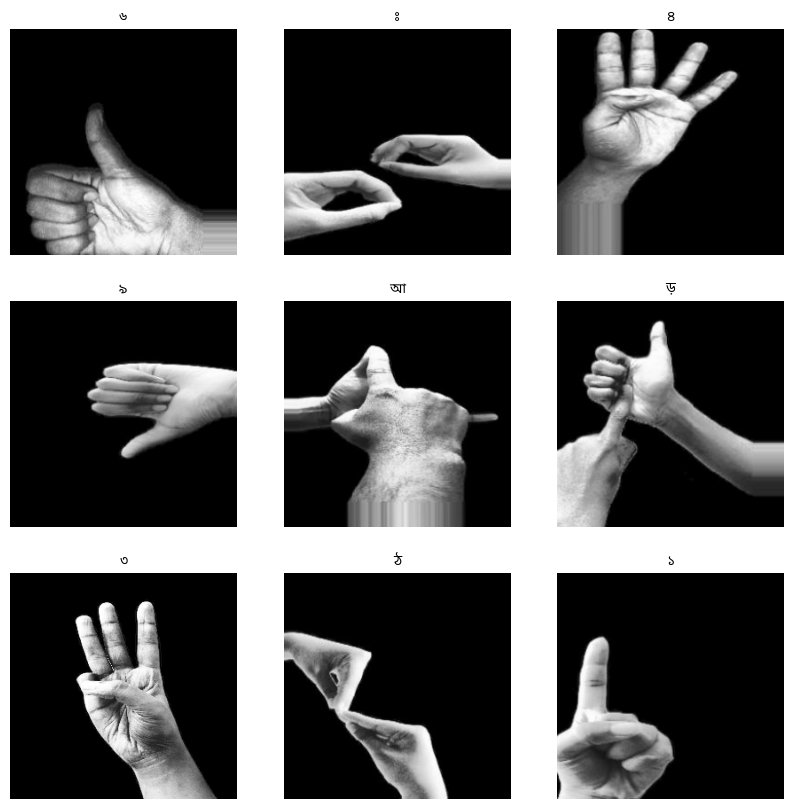

In [13]:
def visualize_predictions(dataset, class_names, num_images=9):
    prop = fm.FontProperties(fname=font_path)
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i].numpy()], fontproperties=prop)
            plt.axis('off')
        plt.show()

visualize_predictions(train_ds, class_name)

# **ResNet50**

In [14]:
# Load the ResNet50 model with pre-trained weights, excluding the top layer
pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze all layers in the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add new layers on top of the pre-trained model
x = pretrained_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(46, activation='softmax')(x)  # Output layer with 46 classes

# Create the final model
ResNet50_model = Model(inputs = pretrained_model.input, outputs = predictions)

ResNet50_model.compile(
    optimizer = Adam(learning_rate = LEARNING_RATE),
    loss = SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
#Train the model
history = ResNet50_model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = 40
)

Epoch 1/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.9657 - loss: 0.1263 - val_accuracy: 0.9093 - val_loss: 0.4002
Epoch 2/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9739 - loss: 0.0774 - val_accuracy: 0.9151 - val_loss: 0.3965
Epoch 3/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9920 - loss: 0.0320 - val_accuracy: 0.9261 - val_loss: 0.3421
Epoch 4/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.9984 - loss: 0.0068 - val_accuracy: 0.9186 - val_loss: 0.3250
Epoch 5/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.9913 - loss: 0.0266 - val_accuracy: 0.8913 - val_loss: 0.5922
Epoch 6/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9805 - loss: 0.0595 - val_accuracy: 0.8992 - val_loss: 0.4192
Epoch 7/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9900 - loss: 0.0347 - val_accuracy: 0.8820 - val_loss: 0.4962
Epoch 8/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9868 - loss: 0.0393 - 

In [18]:
# Evaluate the model on test data
test_loss, test_accuracy = ResNet50_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9158 - loss: 0.3878
Test Loss: 0.41137245297431946
Test Accuracy: 0.9146238565444946


In [19]:
# Save the model
ResNet50_model.save('/kaggle/working/ResNet50_model.h5')

In [28]:
# Verify the saved model
!ls /kaggle/working

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ResNet50_model.h5


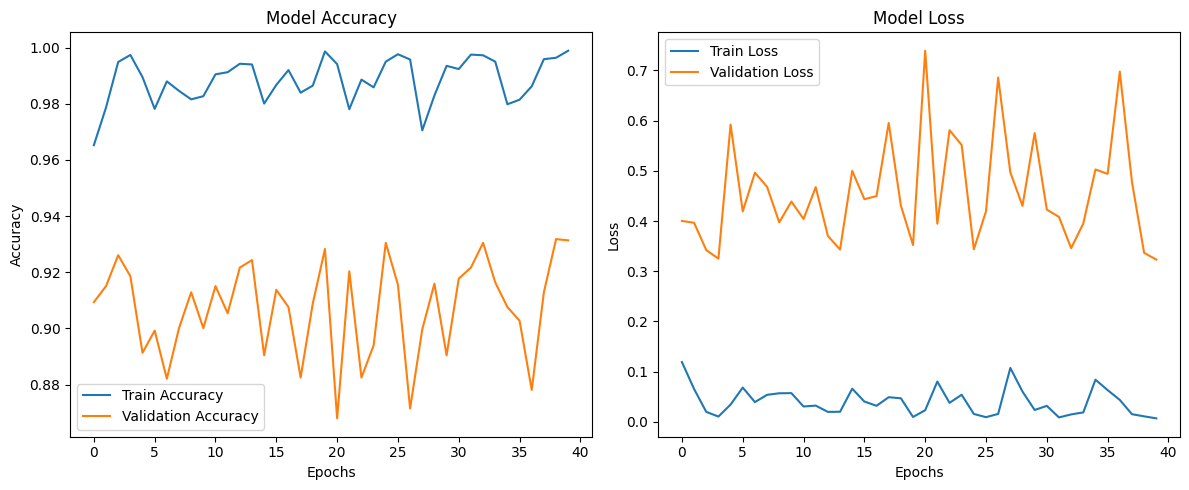

In [20]:
# Plotting the accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
0True: ২
0Pred: ২
1True: চ
1Pred: ছ
2True: দ
2Pred: দ
3True: ন
3Pred: ন
4True: ভ
4Pred: ভ
5True: ক
5Pred: ক
6True: ং
6Pred: ং
7True: ঠ
7Pred: ঠ
8True: ঠ
8Pred: ঠ


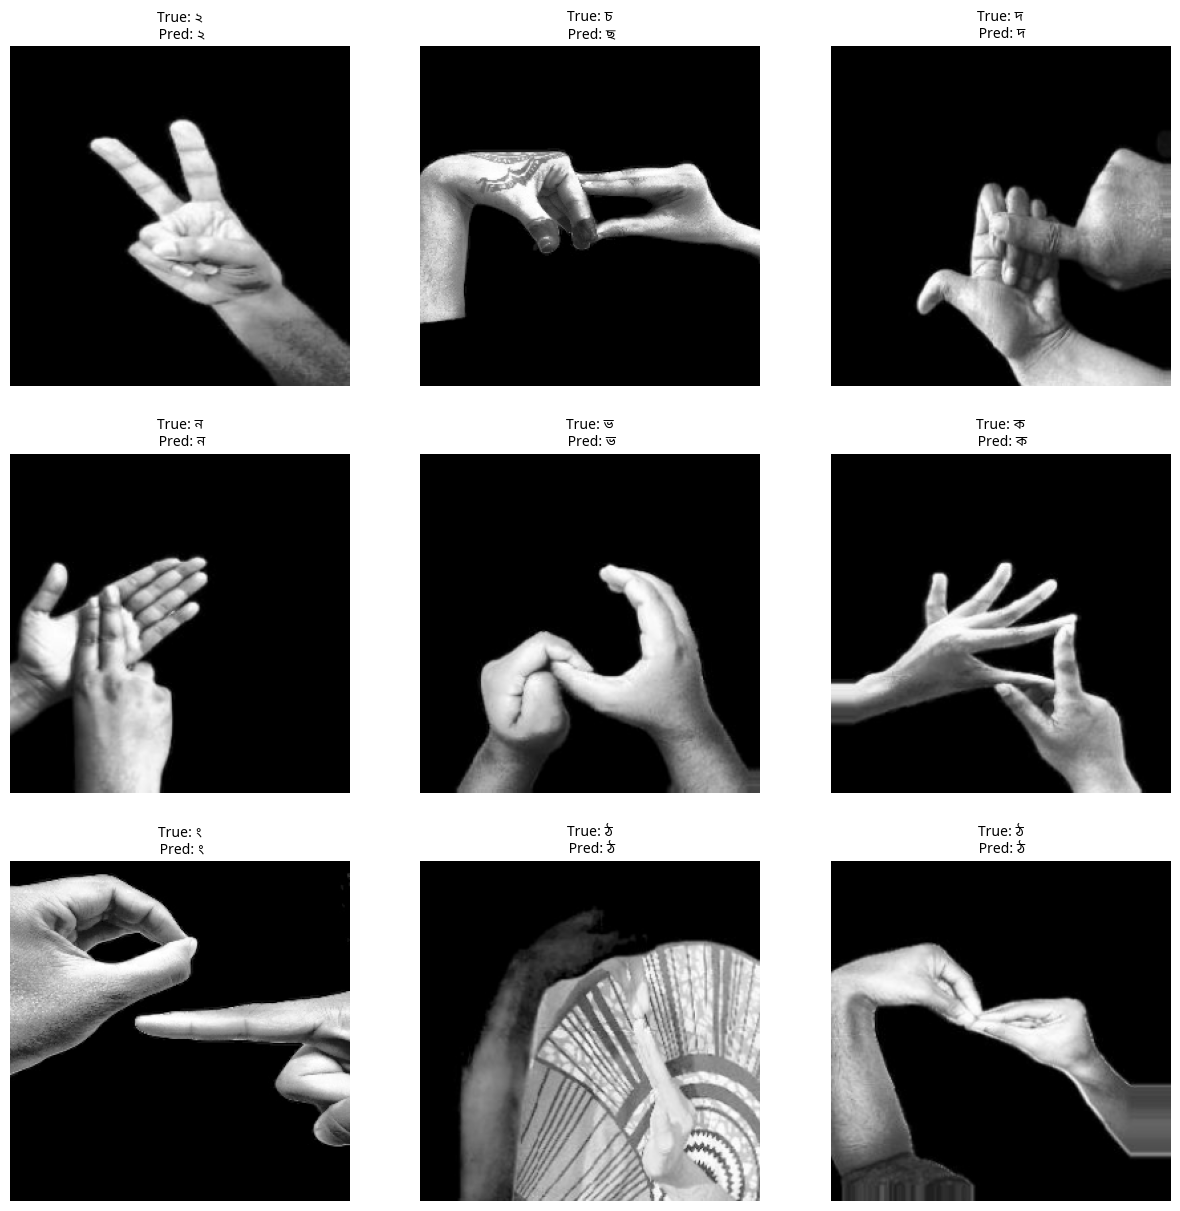

In [21]:
def visualize_predictions(ResNet50_model, dataset, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    images_shown = 0
    prop = fm.FontProperties(fname=font_path)

    for images, labels in dataset.take(1):
        predictions = ResNet50_model.predict(images)
        predicted_labels = tf.argmax(predictions, axis=1)
        
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {class_names[labels[i]]}\n Pred: {class_names[predicted_labels[i]]}", fontproperties=prop)
            plt.axis("off")
            print( f"{i}True: {class_names[labels[i]]}\n{i}Pred: {class_names[predicted_labels[i]]}")
            images_shown += 1
            if images_shown >= num_images:
                break
visualize_predictions(ResNet50_model, test_ds, class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2434 (\N{BENGALI SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2435 (\N{BENGALI SIGN VISARGA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2438 (\N{BENGALI LETTER AA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2439 (\N{BENGALI LETTER I}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: User

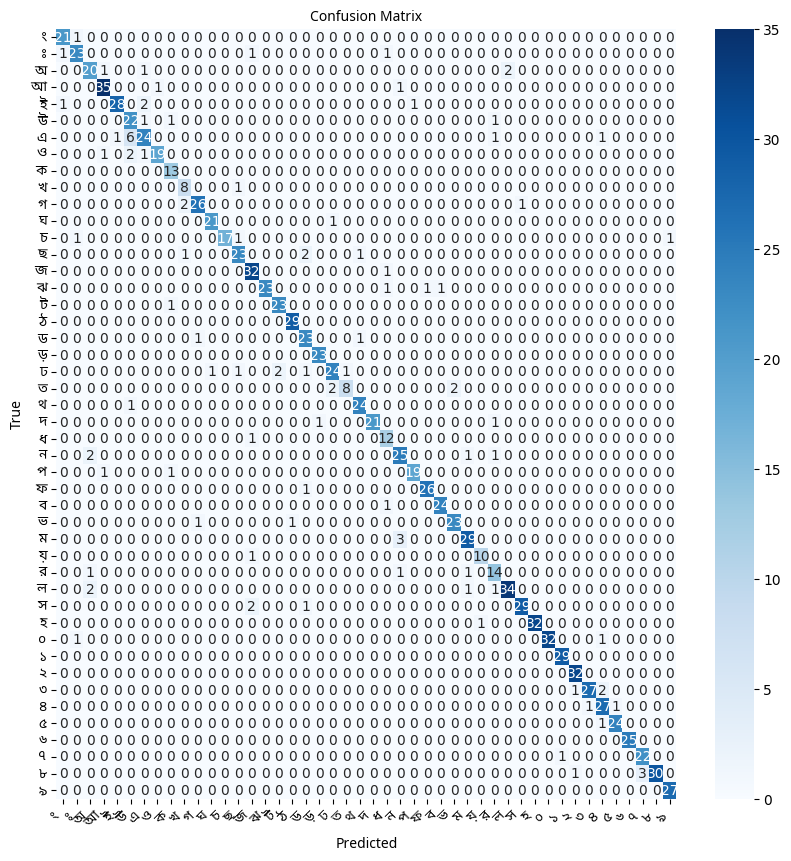

In [22]:
def plot_confusion_matrix(ResNet50_model, dataset, class_names, font_path):
    true_labels = []
    predicted_labels = []

    for images, labels in dataset:
        predictions = ResNet50_model.predict(images)
        predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
        true_labels.extend(labels.numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Load the Bangla font
    prop = fm.FontProperties(fname=font_path)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    # Set the font properties
    plt.xticks(rotation= 45, ha="right", fontproperties=prop)
    plt.yticks(rotation= 0, fontproperties=prop)
    plt.xlabel('Predicted', fontproperties=prop)
    plt.ylabel('True', fontproperties=prop)
    plt.title('Confusion Matrix', fontproperties=prop)
    plt.show()

# Assuming you have a ResNet50_model, test_ds, and class_name defined
plot_confusion_matrix(ResNet50_model, test_ds, class_name, font_path)

In [23]:
def print_classification_report(ResNet50_model, dataset, class_names):
    true_labels = []
    predicted_labels = []
    
    for images, labels in dataset:
        predictions = ResNet50_model.predict(images)
        predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
        true_labels.extend(labels.numpy())
    
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print(report)

print_classification_report(ResNet50_model, test_ds, class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

> **CNN**

In [ ]:
# Define the CNN architecture with input shape (256, 256, 3)
CNN_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Add dropout to prevent overfitting

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Add dropout to prevent overfitting

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Add dropout to prevent overfitting

    Flatten(),
    Dense(256, activation='relu'),  # Increase the number of units in the dense layer
    Dropout(0.2),  # Add dropout to prevent overfitting
    Dense(128, activation='relu'),
    Dropout(0.2),  # Add dropout to prevent overfitting
    Dense(46, activation='softmax')  # Updated to 46 output classes
])

# Compile the model
CNN_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])



In [ ]:
# Define the CNN architecture with input shape (256, 256, 3)
CNN_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Add dropout to prevent overfitting

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Add dropout to prevent overfitting

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Add dropout to prevent overfitting

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Add dropout to prevent overfitting

    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Add dropout to prevent overfitting

    Conv2D(1024, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Add dropout to prevent overfitting

    Flatten(),
    Dense(256, activation='relu'),  # Increase the number of units in the dense layer
    Dropout(0.2),  # Add dropout to prevent overfitting
    Dense(128, activation='relu'),
    Dropout(0.2),  # Add dropout to prevent overfitting
    Dense(46, activation='softmax')  # Updated to 46 output classes
])

# Compile the model
CNN_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

In [ ]:
# Train the model
history = CNN_model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs= EPOCHS
)

In [ ]:
test_loss, test_accuracy = CNN_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

> **VGG16**

In [24]:
# Load the VGG16 model with pre-trained weights, excluding the top layer
pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze all layers in the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add new layers on top of the pre-trained model
x = pretrained_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Optional: Add dropout for regularization
predictions = layers.Dense(46, activation='softmax')(x)  # Output layer with 46 classes

# Create the final model
VGG16_model = Model(inputs=pretrained_model.input, outputs=predictions)

VGG16_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
# Train the model
history = VGG16_model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs= 40
)

Epoch 1/40


2024-06-28 14:09:30.284853: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.31777, expected 2.61172
2024-06-28 14:09:30.284928: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 5.10329, expected 4.39724
2024-06-28 14:09:30.284941: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.80913, expected 4.10308
2024-06-28 14:09:30.284952: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65544: 5.33366, expected 4.62762
2024-06-28 14:09:30.284964: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65545: 5.00267, expected 4.29663
2024-06-28 14:09:30.284976: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65546: 4.93559, expected 4.22954
2024-06-28 14:09:30.284986: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65547: 5.39283, expected 4.68678
2024-06-28 14:09:30.284997:

249/249 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - accuracy: 0.0449 - loss: 19.3141 - val_accuracy: 0.2799 - val_loss: 3.1090
Epoch 2/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - accuracy: 0.1827 - loss: 4.3464 - val_accuracy: 0.3693 - val_loss: 2.3796
Epoch 3/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - accuracy: 0.2651 - loss: 2.9775 - val_accuracy: 0.4643 - val_loss: 2.0128
Epoch 4/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.3468 - loss: 2.4872 - val_accuracy: 0.5343 - val_loss: 1.6860
Epoch 5/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - accuracy: 0.4237 - loss: 2.1298 - val_accuracy: 0.6039 - val_loss: 1.4481
Epoch 6/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - accuracy: 0.4952 - loss: 1.8111 - val_accuracy: 0.6527 - val_loss: 1.2313
Epoch 7/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - accuracy: 0.5716 - loss: 1.5378 - val_accuracy: 0.6972 - val_loss: 1.0739
Epoch 8/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - accuracy: 0.6022 - loss: 1.3598 - val_accur

In [26]:
# Evaluate the model on the test set
test_loss, test_accuracy =VGG16_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


 9/37 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9511 - loss: 0.1617

2024-06-28 14:26:49.108016: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.88794, expected 1.94285
2024-06-28 14:26:49.108071: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.39873, expected 3.45364
2024-06-28 14:26:49.108079: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.25707, expected 3.31198
2024-06-28 14:26:49.108087: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.33792, expected 4.39283
2024-06-28 14:26:49.108095: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.67579, expected 4.73071
2024-06-28 14:26:49.108102: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.44507, expected 4.49998
2024-06-28 14:26:49.108110: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.04956, expected 4.10447
2024-06-28 14:26:49.108117: E external/local_xla/xla/se

37/37 ━━━━━━━━━━━━━━━━━━━━ 22s 609ms/step - accuracy: 0.9424 - loss: 0.1728
Test Loss: 0.17485490441322327
Test Accuracy: 0.9425190091133118


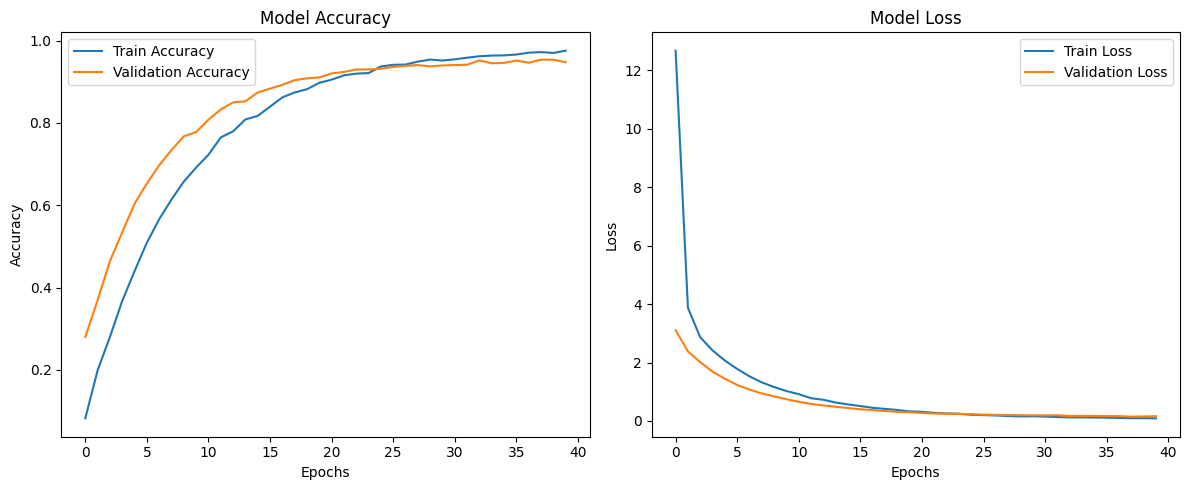

In [27]:
# Plotting the accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Save the model
VGG16_model.save('/kaggle/working/VGG16_model.h5')

# Verify the saved model
!ls /kaggle/working/

VGG16_model.h5


In [24]:
# Print the model summary to confirm it's loaded correctly
VGG16_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 46)             │        47,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,432,076 (62.68 MB)

 Trainable params: 572,462 (2.18 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,144,926 (4.37 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
0True: এ
0Pred: এ
1True: ট
1Pred: ট
2True: ৩
2Pred: ৩
3True: ৩
3Pred: ৩
4True: ছ
4Pred: ছ
5True: এ
5Pred: এ
6True: উ
6Pred: ঢ
7True: অ
7Pred: অ
8True: থ
8Pred: থ


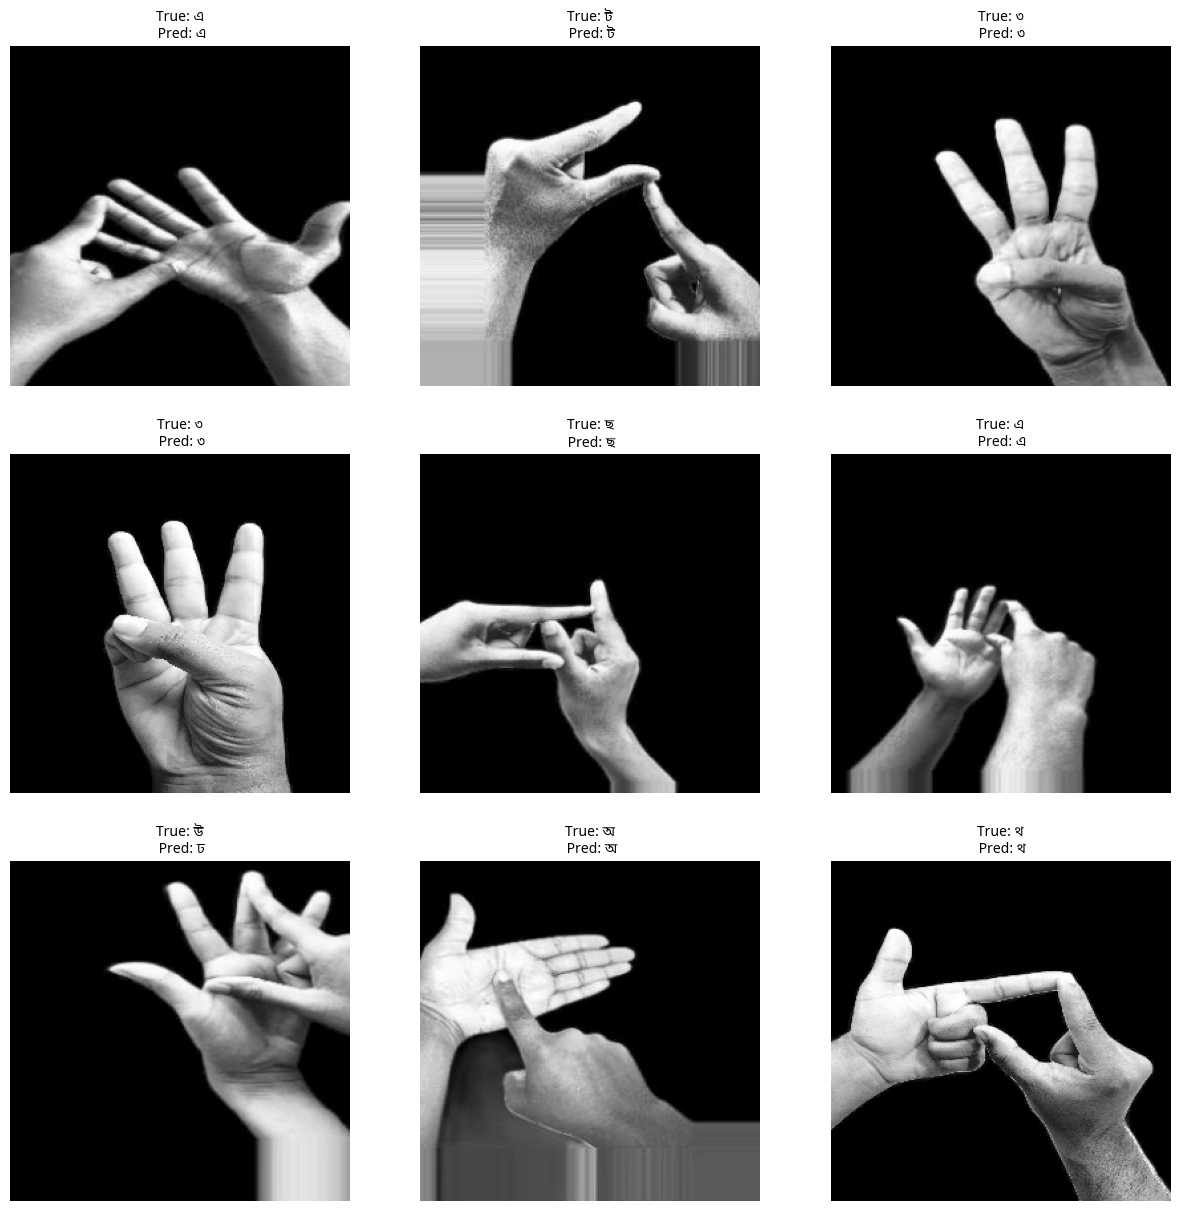

In [29]:
def visualize_predictions(VGG16_model, dataset, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    images_shown = 0
    prop = fm.FontProperties(fname=font_path)

    for images, labels in dataset.take(1):
        predictions = VGG16_model.predict(images)
        predicted_labels = tf.argmax(predictions, axis=1)
        
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {class_names[labels[i]]}\n Pred: {class_names[predicted_labels[i]]}", fontproperties=prop)
            plt.axis("off")
            print( f"{i}True: {class_names[labels[i]]}\n{i}Pred: {class_names[predicted_labels[i]]}")
            images_shown += 1
            if images_shown >= num_images:
                break
visualize_predictions(VGG16_model, test_ds, class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2434 (\N{BENGALI SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2435 (\N{BENGALI SIGN VISARGA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2438 (\N{BENGALI LETTER AA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2439 (\N{BENGALI LETTER I}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: User

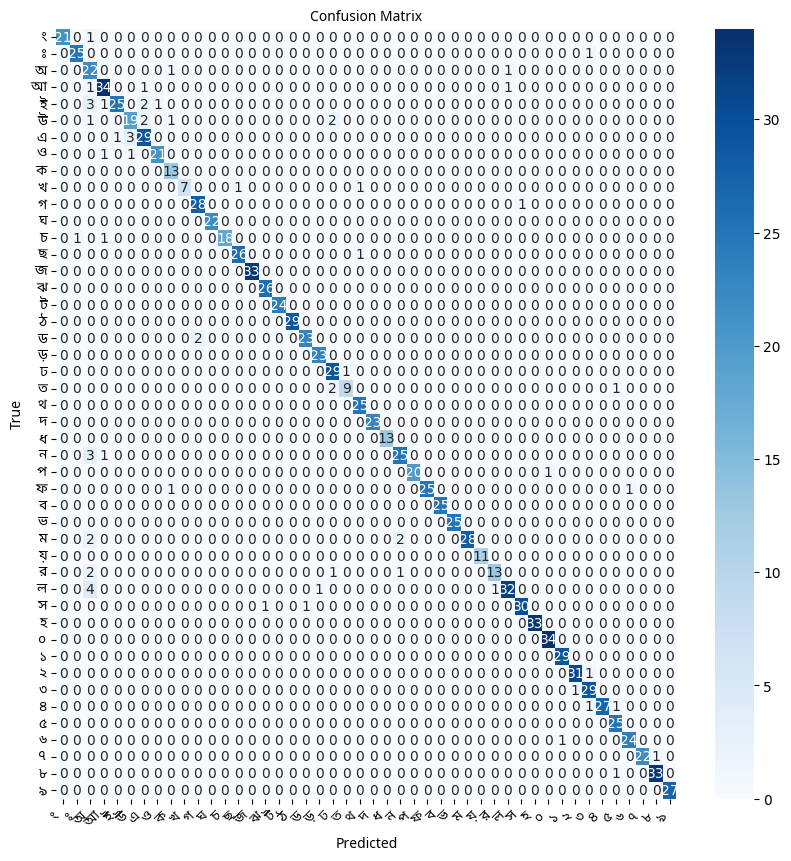

In [30]:
def plot_confusion_matrix(VGG16_model, dataset, class_names, font_path):
    true_labels = []
    predicted_labels = []

    for images, labels in dataset:
        predictions = VGG16_model.predict(images)
        predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
        true_labels.extend(labels.numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Load the Bangla font
    prop = fm.FontProperties(fname=font_path)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")

    # Set the font properties
    plt.xticks(rotation= 45, ha="right", fontproperties=prop)
    plt.yticks(rotation= 0, fontproperties=prop)
    plt.xlabel('Predicted', fontproperties=prop)
    plt.ylabel('True', fontproperties=prop)
    plt.title('Confusion Matrix', fontproperties=prop)
    plt.show()

# Assuming you have a VGG16_model, test_ds, and class_name defined
plot_confusion_matrix(VGG16_model, test_ds, class_name, font_path)

In [31]:
def print_classification_report(VGG16_model, dataset, class_names):
    true_labels = []
    predicted_labels = []
    
    for images, labels in dataset:
        predictions = VGG16_model.predict(images)
        predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
        true_labels.extend(labels.numpy())
    
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print(report)

print_classification_report(VGG16_model, test_ds, class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

> **VGG19**

In [14]:
# Load the VGG19 model with pre-trained weights, excluding the top layer
pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze all layers in the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add new layers on top of the pre-trained model
x = pretrained_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Optional: Add dropout for regularization
predictions = layers.Dense(46, activation='softmax')(x)   # Output layer with 46 classes

# Create the final model
VGG19_model = Model(inputs=pretrained_model.input, outputs=predictions)
VGG19_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [15]:
# Train the model
VGG19_model_history = VGG19_model.fit(
    train_ds,
    epochs=EPOCHS,  # Adjust the number of epochs as needed
    validation_data=val_ds
)

Epoch 1/50


2024-06-27 05:23:57.196260: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.31777, expected 2.61172
2024-06-27 05:23:57.196317: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 5.10329, expected 4.39724
2024-06-27 05:23:57.196336: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.80913, expected 4.10308
2024-06-27 05:23:57.196352: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65544: 5.33366, expected 4.62762
2024-06-27 05:23:57.196362: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65545: 5.00267, expected 4.29663
2024-06-27 05:23:57.196372: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65546: 4.93559, expected 4.22954
2024-06-27 05:23:57.196383: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65547: 5.39283, expected 4.68678
2024-06-27 05:23:57.196394:

  2/249 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.0312 - loss: 35.7606   

I0000 00:00:1719465858.924401      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/249 ━━━━━━━━━━━━━━━━━━━━ 67s 168ms/step - accuracy: 0.0445 - loss: 22.7212 - val_accuracy: 0.2751 - val_loss: 3.4750
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - accuracy: 0.1812 - loss: 4.8877 - val_accuracy: 0.3556 - val_loss: 2.5302
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - accuracy: 0.2474 - loss: 3.1654 - val_accuracy: 0.4397 - val_loss: 2.1609
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.3232 - loss: 2.6712 - val_accuracy: 0.5079 - val_loss: 1.8587
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.3992 - loss: 2.2512 - val_accuracy: 0.5915 - val_loss: 1.5434
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.4834 - loss: 1.9040 - val_accuracy: 0.6439 - val_loss: 1.3389
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.5361 - loss: 1.6515 - val_accuracy: 0.6884 - val_loss: 1.1510
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - accuracy: 0.5867 - loss: 1.4177 - va

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = VGG19_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

21/37 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9520 - loss: 0.1859

2024-06-27 06:14:55.265363: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.88794, expected 1.94285
2024-06-27 06:14:55.265433: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.39873, expected 3.45364
2024-06-27 06:14:55.265443: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.25707, expected 3.31198
2024-06-27 06:14:55.265451: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.33792, expected 4.39283
2024-06-27 06:14:55.265459: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.67579, expected 4.73071
2024-06-27 06:14:55.265467: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.44507, expected 4.49998
2024-06-27 06:14:55.265475: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.04956, expected 4.10447
2024-06-27 06:14:55.265482: E external/local_xla/xla/se

37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 626ms/step - accuracy: 0.9521 - loss: 0.1773
Test Loss: 0.15576320886611938
Test Accuracy: 0.9543533325195312


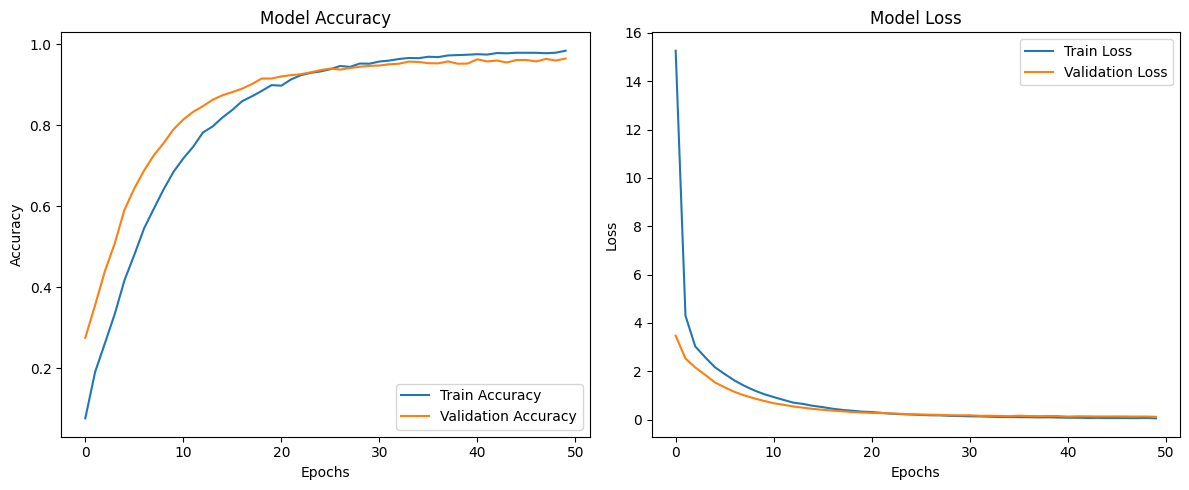

In [18]:
# Plotting the accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(VGG19_model_history.history['accuracy'], label='Train Accuracy')
plt.plot(VGG19_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the loss
plt.subplot(1, 2, 2)
plt.plot(VGG19_model_history.history['loss'], label='Train Loss')
plt.plot(VGG19_model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Save the model
VGG19_model.save('/kaggle/working/VGG19_model.h5')

# Verify the saved model
!ls /kaggle/working/

VGG19_model.h5


In [20]:
# Print the model summary to confirm it's loaded correctly
VGG19_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,741,772 (82.94 MB)

 Trainable params: 572,462 (2.18 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 1,144,926 (4.37 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0True: ও
0Pred: ও
1True: ই
1Pred: ই
2True: জ
2Pred: জ
3True: ৯
3Pred: ৯
4True: ঝ
4Pred: ঝ
5True: ০
5Pred: ০
6True: উ
6Pred: উ
7True: স
7Pred: স
8True: র
8Pred: র


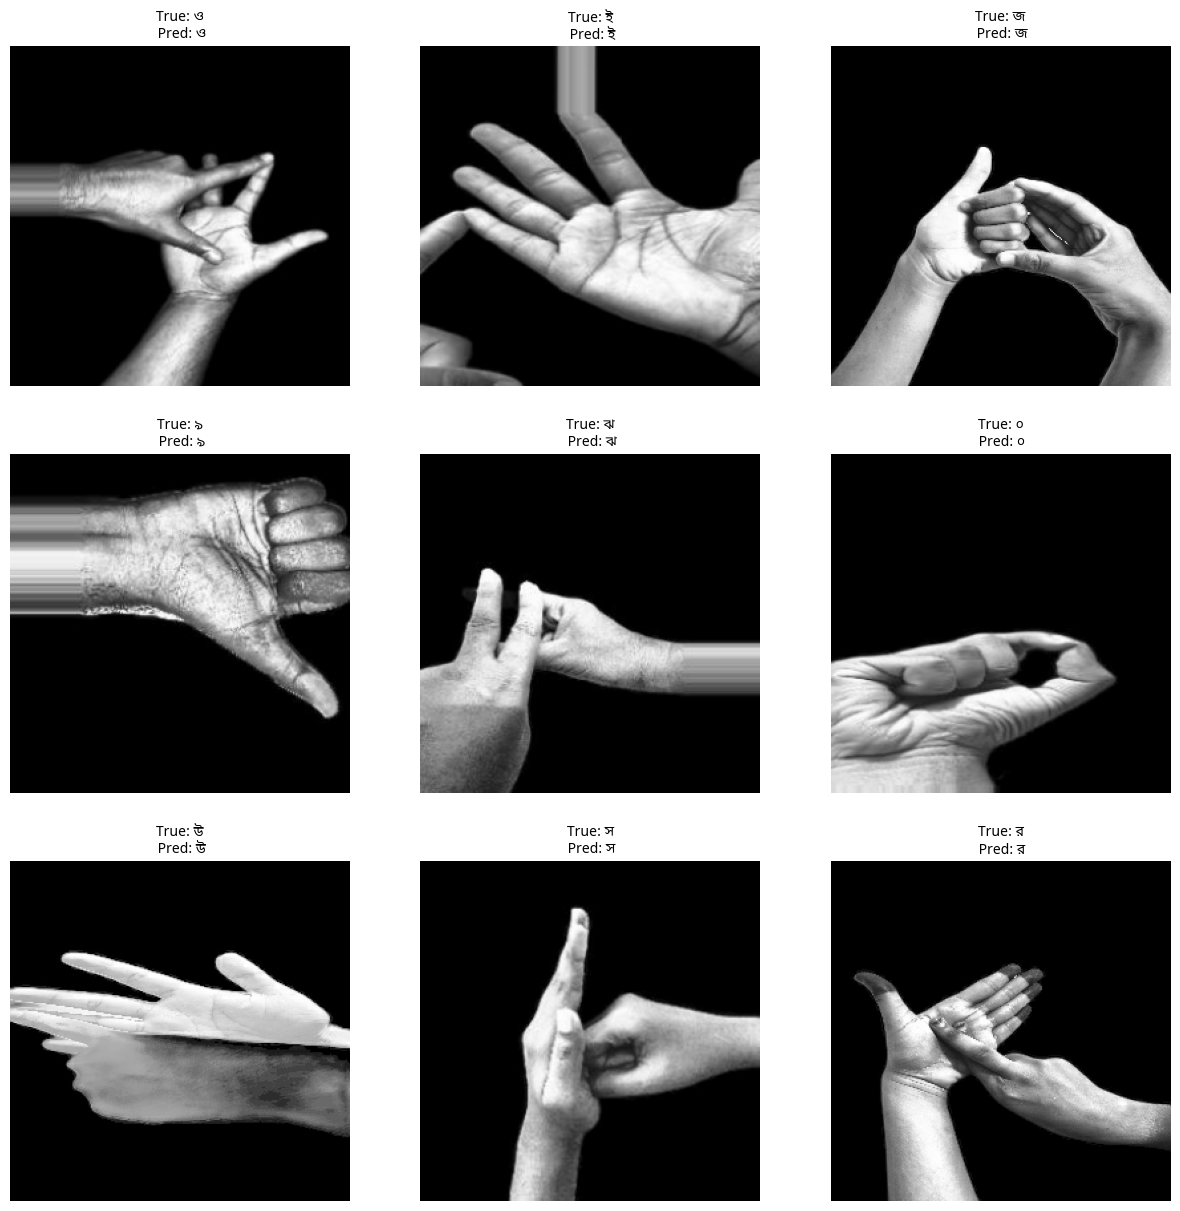

In [25]:
def visualize_predictions(VGG19_model, dataset, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    images_shown = 0
    prop = fm.FontProperties(fname=font_path)

    for images, labels in dataset.take(1):
        predictions = VGG19_model.predict(images)
        predicted_labels = tf.argmax(predictions, axis=1)
        
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {class_names[labels[i]]}\n Pred: {class_names[predicted_labels[i]]}", fontproperties=prop)
            plt.axis("off")
            print( f"{i}True: {class_names[labels[i]]}\n{i}Pred: {class_names[predicted_labels[i]]}")
            images_shown += 1
            if images_shown >= num_images:
                break
visualize_predictions(VGG19_model, test_ds, class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━

/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2434 (\N{BENGALI SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2435 (\N{BENGALI SIGN VISARGA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2438 (\N{BENGALI LETTER AA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2439 (\N{BENGALI LETTER I}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: User

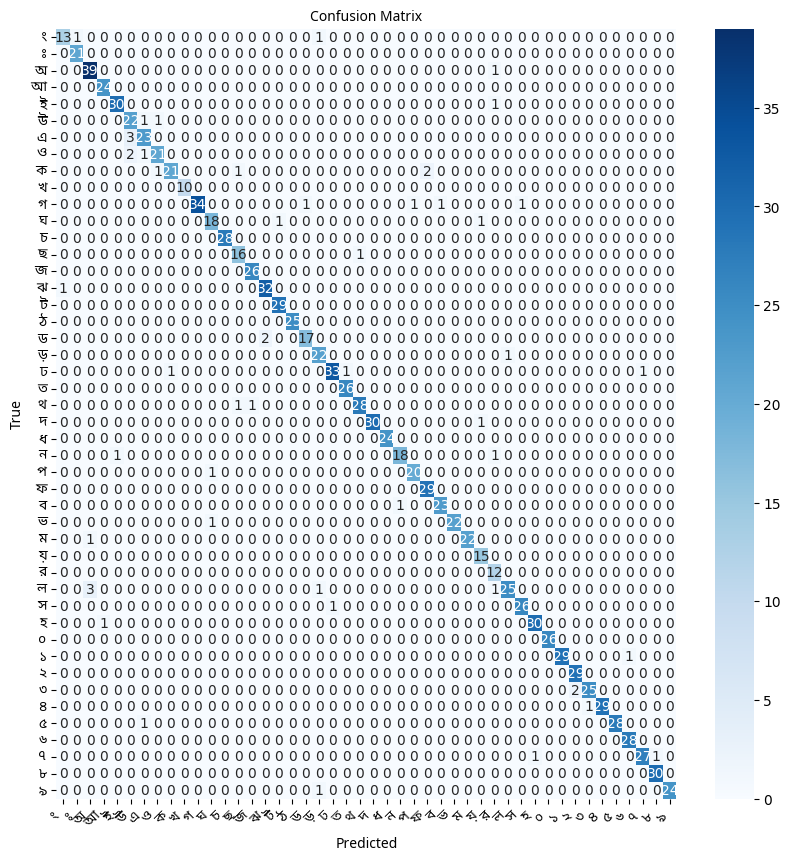

In [26]:
def plot_confusion_matrix(VGG19_model, dataset, class_names, font_path):
    true_labels = []
    predicted_labels = []

    for images, labels in dataset:
        predictions = VGG19_model.predict(images)
        predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
        true_labels.extend(labels.numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Load the Bangla font
    prop = fm.FontProperties(fname=font_path)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")

    # Set the font properties
    plt.xticks(rotation= 45, ha="right", fontproperties=prop)
    plt.yticks(rotation= 0, fontproperties=prop)
    plt.xlabel('Predicted', fontproperties=prop)
    plt.ylabel('True', fontproperties=prop)
    plt.title('Confusion Matrix', fontproperties=prop)
    plt.show()

# Assuming you have a VGG19_model, test_ds, and class_name defined
plot_confusion_matrix(VGG19_model, test_ds, class_name, font_path)

In [27]:
def print_classification_report(VGG19_model, dataset, class_names):
    true_labels = []
    predicted_labels = []
    
    for images, labels in dataset:
        predictions = VGG19_model.predict(images)
        predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
        true_labels.extend(labels.numpy())
    
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print(report)

print_classification_report(VGG19_model, test_ds, class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

> **InceptionV3**

In [44]:
# Load the InceptionV3 model with pre-trained weights, excluding the top layer
pretrained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Unfreeze the last few layers of the pre-trained model
for layer in pretrained_model.layers[:200]:
    layer.trainable = False
    
# Add new layers on top of the pre-trained model
x = pretrained_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Increased number of neurons
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(46, activation='softmax')(x)  # Output layer with 46 classes

# Create the final model
InceptionV3_model = Model(inputs=pretrained_model.input, outputs=predictions)

InceptionV3_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Adjust the learning rate as needed
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Learning rate scheduler
lr_reduce = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=0.00001
)

# Early stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [45]:
# Train the model
history = InceptionV3_model.fit(
    train_ds,
    epochs=40,  # Adjust the number of epochs as needed
    validation_data=val_ds,
    callbacks=[lr_reduce, early_stopping]
)

Epoch 1/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 62s 116ms/step - accuracy: 0.1047 - loss: 5.9588 - val_accuracy: 0.3587 - val_loss: 4.4786 - learning_rate: 1.0000e-04
Epoch 2/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.5356 - loss: 3.6526 - val_accuracy: 0.5405 - val_loss: 3.6747 - learning_rate: 1.0000e-04
Epoch 3/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.8294 - loss: 2.6119 - val_accuracy: 0.6571 - val_loss: 3.1887 - learning_rate: 1.0000e-04
Epoch 4/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.9617 - loss: 2.0994 - val_accuracy: 0.6915 - val_loss: 3.0372 - learning_rate: 1.0000e-04
Epoch 5/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.9957 - loss: 1.9201 - val_accuracy: 0.7020 - val_loss: 2.9300 - learning_rate: 1.0000e-04
Epoch 6/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.9970 - loss: 1.8343 - val_accuracy: 0.7077 - val_loss: 2.8290 - learning_rate: 1.0000e-04
Epoch 7/40
249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/st

In [46]:
# Evaluate the model on the test set
test_loss, test_accuracy = InceptionV3_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.6966 - loss: 1.1397
Test Loss: 1.2407277822494507
Test Accuracy: 0.668639063835144


In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Save the model
InceptionV3_model.save('/kaggle/working/InceptionV3_model.h5')

# Verify the saved model
!ls /kaggle/working/

In [ ]:
InceptionV3_model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0True: এ
0Pred: উ
1True: ট
1Pred: ত
2True: ৩
2Pred: ৩
3True: ৩
3Pred: ৩
4True: ছ
4Pred: ছ
5True: এ
5Pred: উ
6True: উ
6Pred: ৫
7True: অ
7Pred: অ
8True: থ
8Pred: থ


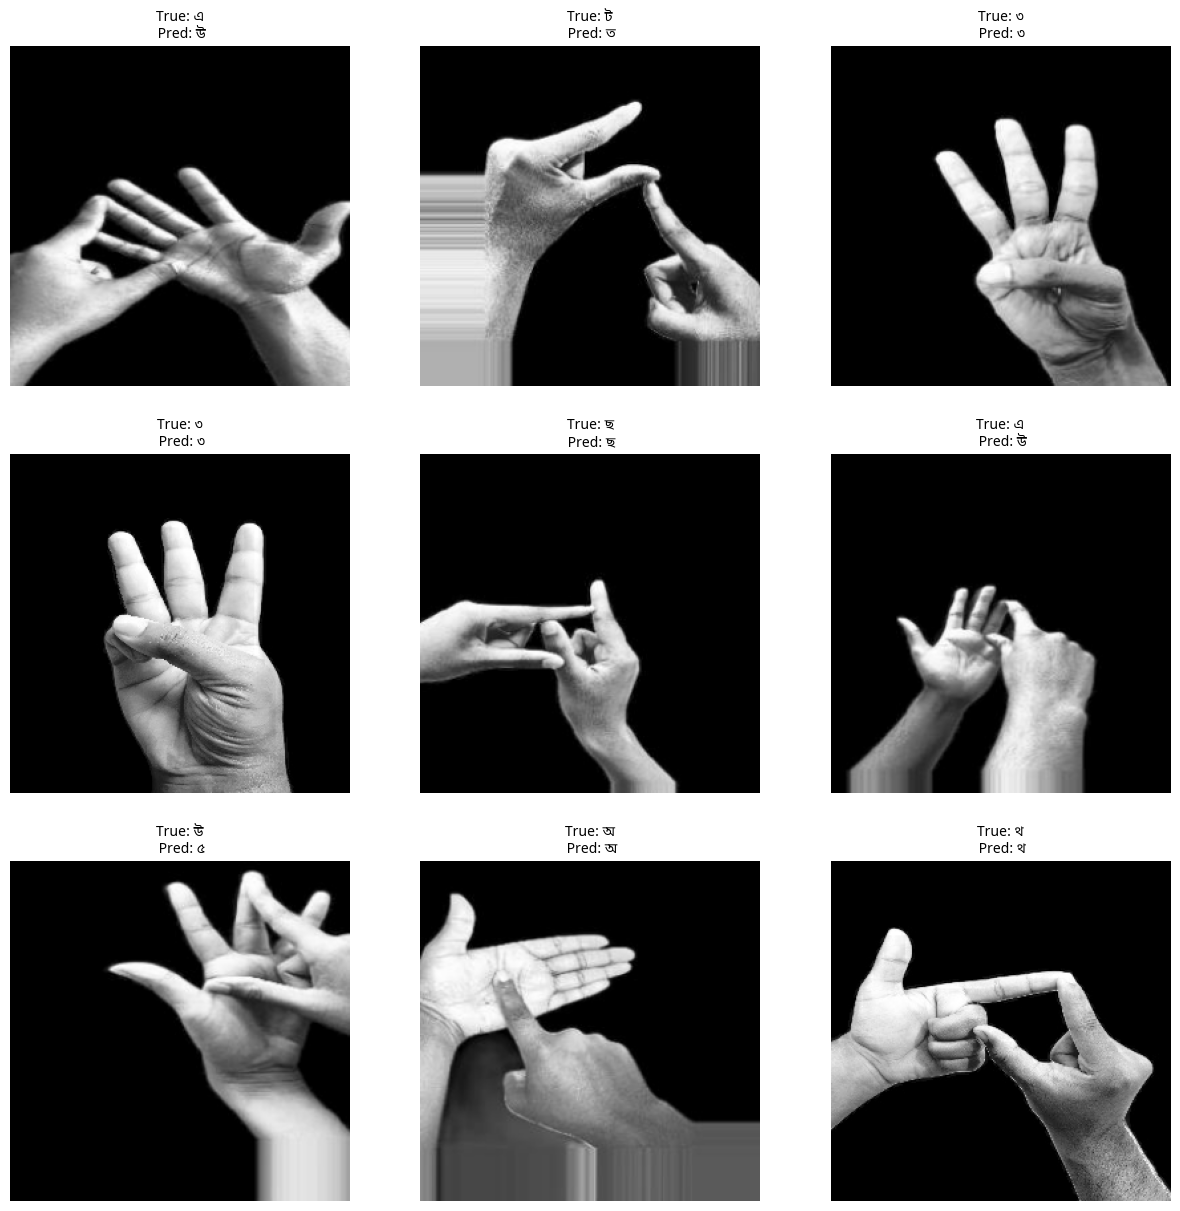

In [50]:
def visualize_predictions(InceptionV3_model, dataset, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    images_shown = 0
    prop = fm.FontProperties(fname=font_path)

    for images, labels in dataset.take(1):
        predictions = InceptionV3_model.predict(images)
        predicted_labels = tf.argmax(predictions, axis=1)
        
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {class_names[labels[i]]}\n Pred: {class_names[predicted_labels[i]]}", fontproperties=prop)
            plt.axis("off")
            print( f"{i}True: {class_names[labels[i]]}\n{i}Pred: {class_names[predicted_labels[i]]}")
            images_shown += 1
            if images_shown >= num_images:
                break
visualize_predictions (InceptionV3_model, test_ds, class_name)

In [ ]:
def plot_confusion_matrix(InceptionV3_model, dataset, class_names, font_path):
    true_labels = []
    predicted_labels = []

    for images, labels in dataset:
        predictions = InceptionV3_model.predict(images)
        predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
        true_labels.extend(labels.numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Load the Bangla font
    prop = fm.FontProperties(fname=font_path)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")

    # Set the font properties
    plt.xticks(rotation= 45, ha="right", fontproperties=prop)
    plt.yticks(rotation= 0, fontproperties=prop)
    plt.xlabel('Predicted', fontproperties=prop)
    plt.ylabel('True', fontproperties=prop)
    plt.title('Confusion Matrix', fontproperties=prop)
    plt.show()

# Assuming you have a InceptionV3_model, test_ds, and class_name defined
plot_confusion_matrix(InceptionV3_model, test_ds, class_name, font_path)

In [ ]:
def print_classification_report(InceptionV3_model, dataset, class_names):
    true_labels = []
    predicted_labels = []
    
    for images, labels in dataset:
        predictions = InceptionV3_model.predict(images)
        predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
        true_labels.extend(labels.numpy())
    
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print(report)

print_classification_report(InceptionV3_model, test_ds, class_name)

# **Hybrid**

In [32]:
num_classes = len(class_name)

# Load InceptionV3 and ResNet50 with pre-trained weights
input_shape = (256, 256, 3)
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Fine-tune the top layers of InceptionV3 and ResNet50
for layer in inception_base.layers[-50:]:
    layer.trainable = True
for layer in resnet_base.layers[-50:]:
    layer.trainable = True

# Create input layer
input_tensor = Input(shape=input_shape)

# Extract features using both modelsa
inception_features = inception_base(input_tensor)
resnet_features = resnet_base(input_tensor)

# Pool the features
inception_pool = GlobalAveragePooling2D()(inception_features)
resnet_pool = GlobalAveragePooling2D()(resnet_features)

# Concatenate the pooled features
combined_features = Concatenate()([inception_pool, resnet_pool])

# Add fully connected layers with L2 regularization
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(combined_features)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output_tensor = Dense(num_classes, activation='softmax')(x)

# Create the hybrid model
hybrid_model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model with a lower initial learning rate and a learning rate scheduler
hybrid_model.compile(optimizer=Adam(learning_rate=0.00001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Learning rate scheduler
lr_reduce = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=0.00001
)

# Early stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [33]:
# Train the model with augmented data and fine-tuned layers
Hybrid_history = hybrid_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, lr_reduce]
)

Epoch 1/50


W0000 00:00:1719585176.484049     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.0316 - loss: 27.0288

W0000 00:00:1719585269.164672     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


249/249 ━━━━━━━━━━━━━━━━━━━━ 267s 401ms/step - accuracy: 0.0317 - loss: 27.0275 - val_accuracy: 0.1056 - val_loss: 25.9618 - learning_rate: 1.0000e-05
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 90s 361ms/step - accuracy: 0.0889 - loss: 25.7296 - val_accuracy: 0.2232 - val_loss: 24.6797 - learning_rate: 1.0000e-05
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 90s 360ms/step - accuracy: 0.2079 - loss: 24.4161 - val_accuracy: 0.4573 - val_loss: 23.1632 - learning_rate: 1.0000e-05
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 90s 361ms/step - accuracy: 0.3303 - loss: 23.1372 - val_accuracy: 0.6048 - val_loss: 21.8620 - learning_rate: 1.0000e-05
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 90s 361ms/step - accuracy: 0.4800 - loss: 21.8963 - val_accuracy: 0.7077 - val_loss: 20.7555 - learning_rate: 1.0000e-05
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 90s 361ms/step - accuracy: 0.5796 - loss: 20.8190 - val_accuracy: 0.7804 - val_loss: 19.7815 - learning_rate: 1.0000e-05
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 90s 

In [34]:
test_loss, test_accuracy = hybrid_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

 7/37 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.9632 - loss: 0.5181

W0000 00:00:1719589749.085108     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 417ms/step - accuracy: 0.9572 - loss: 0.5500
Test Loss: 0.5463759303092957
Test Accuracy: 0.9602705240249634


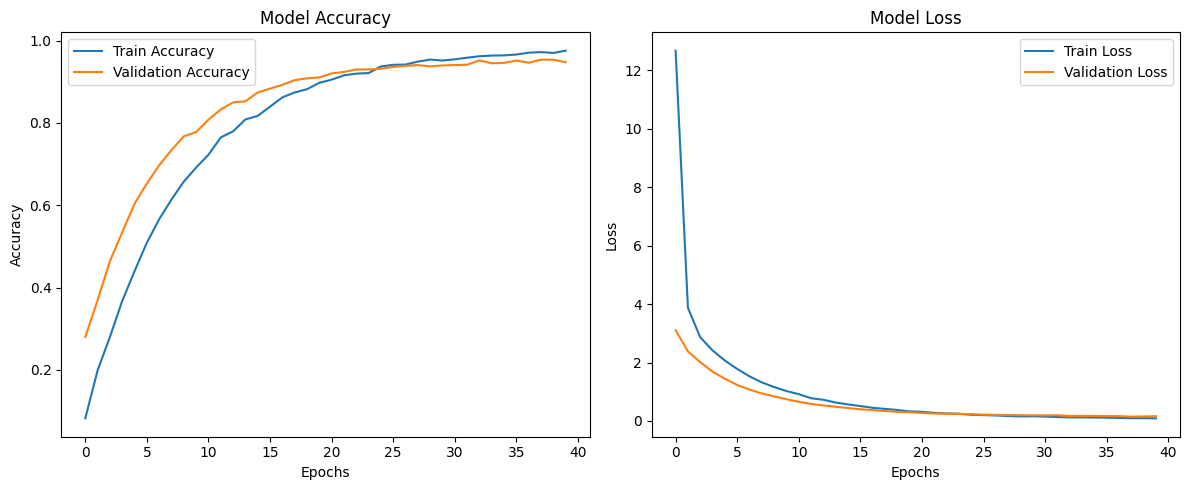

In [35]:
# Plotting the accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# Save the model
hybrid_model.save('/kaggle/working/hybrid_modelV2.h5')

# Verify the saved model
!ls /kaggle/working/

hybrid_model.h5  hybrid_model.zip  hybrid_model2.h5  hybrid_modelV2.h5


In [25]:
# Print the model summary to confirm it's loaded correctly
hybrid_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 6, 6,      │ 21,802,784 │ input_layer_2[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ input_layer_2[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ inception_v3[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 4096)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  4,195,328 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 46)        │     23,598 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 150,227,564 (573.07 MB)

 Trainable params: 50,046,670 (190.91 MB)

 Non-trainable params: 87,552 (342.00 KB)

 Optimizer params: 100,093,342 (381.83 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0True: ৪
0Pred: ৪
1True: ল
1Pred: ল
2True: অ
2Pred: অ
3True: আ
3Pred: আ
4True: ব
4Pred: ব
5True: আ
5Pred: আ
6True: ৫
6Pred: ৫
7True: ড়
7Pred: ড়
8True: ই
8Pred: ই


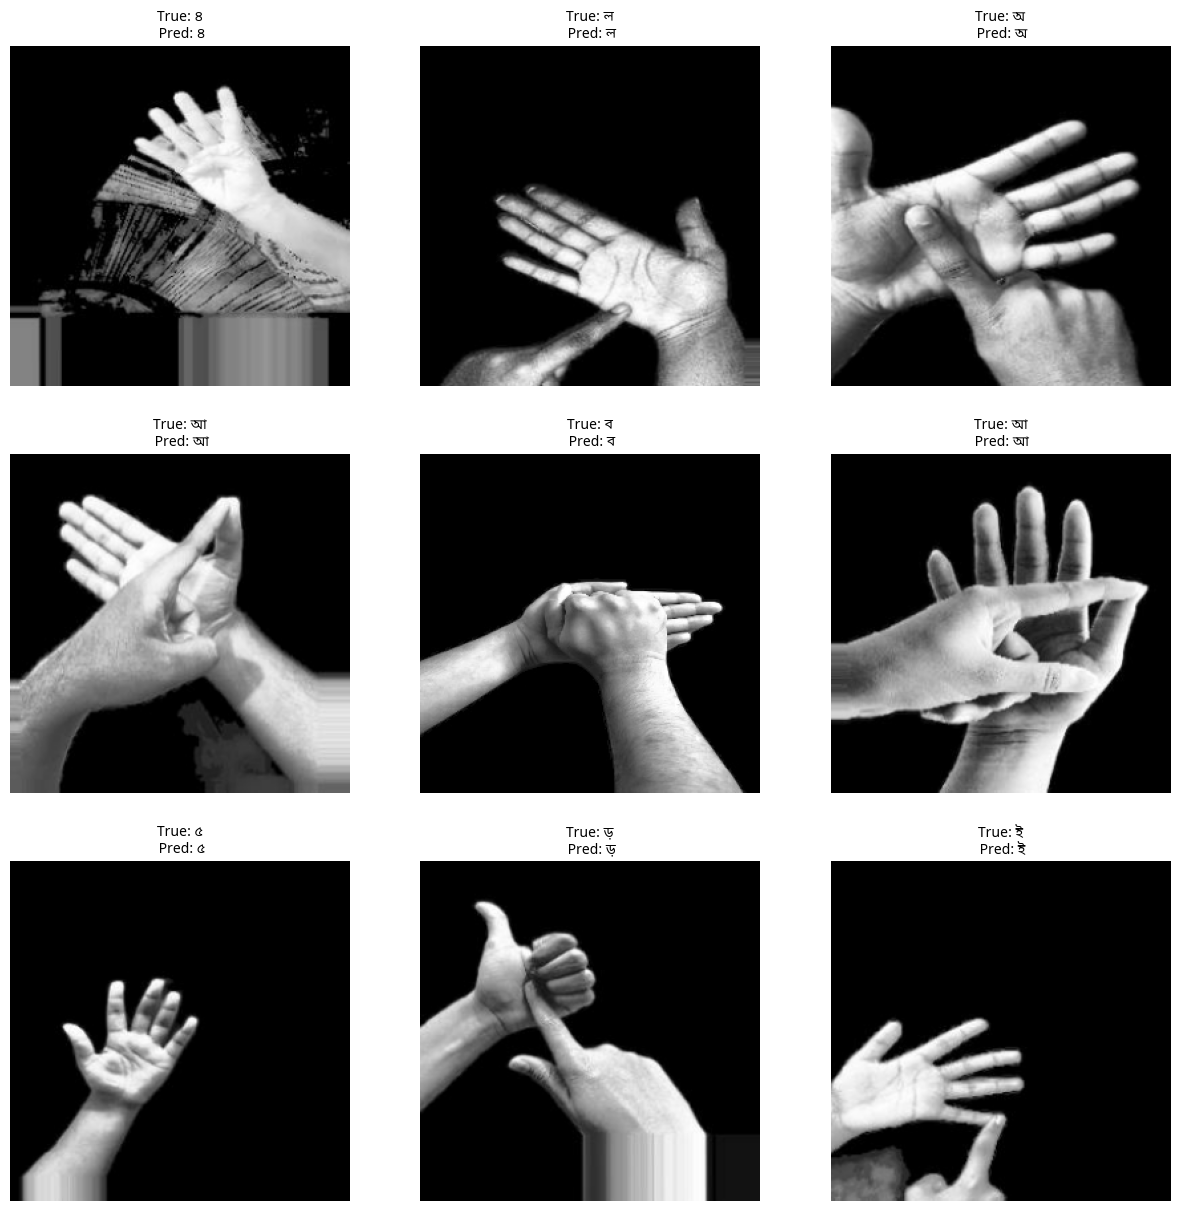

In [39]:
def visualize_predictions(hybrid_model, dataset, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    images_shown = 0
    prop = fm.FontProperties(fname=font_path)

    for images, labels in dataset.take(1):
        predictions = hybrid_model.predict(images)
        predicted_labels = tf.argmax(predictions, axis=1)
        
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {class_names[labels[i]]}\n Pred: {class_names[predicted_labels[i]]}", fontproperties=prop)
            plt.axis("off")
            print( f"{i}True: {class_names[labels[i]]}\n{i}Pred: {class_names[predicted_labels[i]]}")
            images_shown += 1
            if images_shown >= num_images:
                break
visualize_predictions(hybrid_model, test_ds, class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

W0000 00:00:1719589837.161280     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2434 (\N{BENGALI SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2435 (\N{BENGALI SIGN VISARGA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2438 (\N{BENGALI LETTER AA}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 2439 (\N{BENGALI LETTER I}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: User

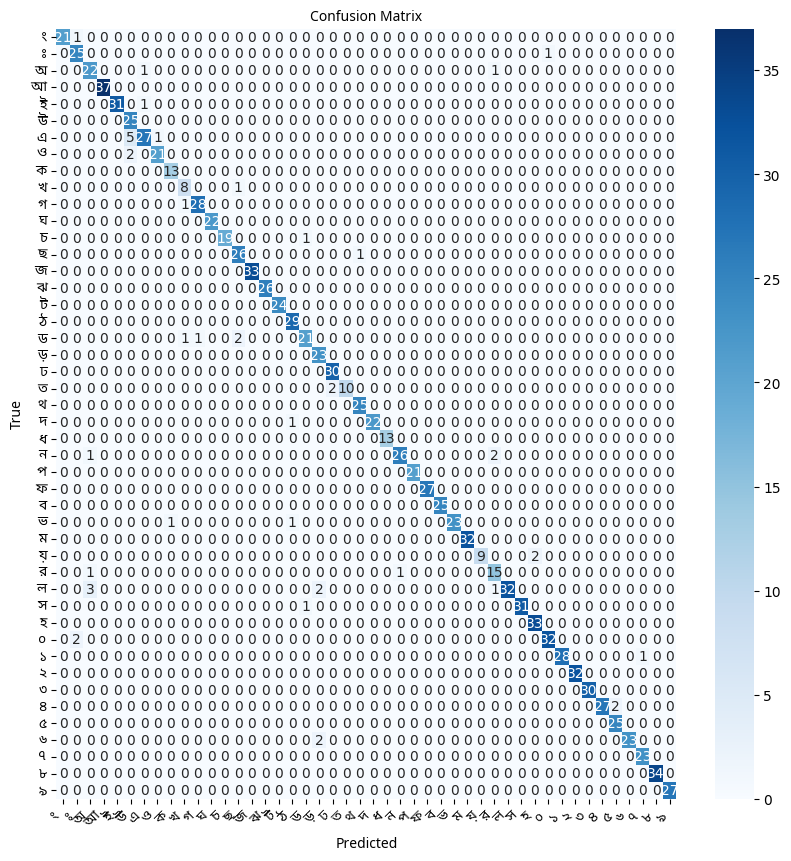

In [40]:
def plot_confusion_matrix(hybrid_model, dataset, class_names, font_path):
    true_labels = []
    predicted_labels = []

    for images, labels in dataset:
        predictions = hybrid_model.predict(images)
        predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
        true_labels.extend(labels.numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Load the Bangla font
    prop = fm.FontProperties(fname=font_path)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")

    # Set the font properties
    plt.xticks(rotation= 45, ha="right", fontproperties=prop)
    plt.yticks(rotation= 0, fontproperties=prop)
    plt.xlabel('Predicted', fontproperties=prop)
    plt.ylabel('True', fontproperties=prop)
    plt.title('Confusion Matrix', fontproperties=prop)
    plt.show()

# Assuming you have a hybrid_model, test_ds, and class_name defined
plot_confusion_matrix(hybrid_model, test_ds, class_name, font_path)

In [41]:
def print_classification_report(hybrid_model, dataset, class_names):
    true_labels = []
    predicted_labels = []
    
    for images, labels in dataset:
        predictions = hybrid_model.predict(images)
        predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
        true_labels.extend(labels.numpy())
    
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print(report)

print_classification_report(hybrid_model, test_ds, class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

> **Xecpetion Model**

In [42]:
# Define number of classes
num_classes = len(class_name)

# Load Xception with pre-trained weights
input_shape = (256, 256, 3)
xception_base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

# Fine-tune the top layers of Xception
for layer in xception_base.layers[-50:]:
    layer.trainable = True

# Create input layer
input_tensor = Input(shape=input_shape)

# Extract features using Xception
xception_features = xception_base(input_tensor)

# Pool the features
xception_pool = GlobalAveragePooling2D()(xception_features)

# Add fully connected layers with L2 regularization-
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(xception_pool)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output_tensor = Dense(num_classes, activation='softmax')(x)
# Create the Xception model
xception_model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model with a lower initial learning rate and a learning rate scheduler
xception_model.compile(optimizer=Adam(learning_rate=0.00001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
# Learning rate scheduler
lr_reduce = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=0.00001
)

# Early stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [43]:
# Train the model with more epochs and fine-tuned layers
history = xception_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 40,  # Increased the number of epochs
    callbacks=[early_stopping, lr_reduce]
)

Epoch 1/40



KeyboardInterrupt



In [ ]:
# Evaluate the Xception model on the test set
test_loss, test_accuracy = xception_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Save the model
hybrid_model.save('/kaggle/working/xception_model.h5')

# Verify the saved model
!ls /kaggle/working/

In [ ]:
# Print the model summary to confirm it's loaded correctly
xception_model.summary()

In [ ]:
def visualize_predictions(xception_model, dataset, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    images_shown = 0
    prop = fm.FontProperties(fname=font_path)

    for images, labels in dataset.take(1):
        predictions = xception_model.predict(images)
        predicted_labels = tf.argmax(predictions, axis=1)
        
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {class_names[labels[i]]}\n Pred: {class_names[predicted_labels[i]]}", fontproperties=prop)
            plt.axis("off")
            print( f"{i}True: {class_names[labels[i]]}\n{i}Pred: {class_names[predicted_labels[i]]}")
            images_shown += 1
            if images_shown >= num_images:
                break
visualize_predictions(xception_model, test_ds, class_name)

In [ ]:
def plot_confusion_matrix(xception_model, dataset, class_names, font_path):
    true_labels = []
    predicted_labels = []

    for images, labels in dataset:
        predictions = xception_model.predict(images)
        predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
        true_labels.extend(labels.numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Load the Bangla font
    prop = fm.FontProperties(fname=font_path)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")

    # Set the font properties
    plt.xticks(rotation= 45, ha="right", fontproperties=prop)
    plt.yticks(rotation= 0, fontproperties=prop)
    plt.xlabel('Predicted', fontproperties=prop)
    plt.ylabel('True', fontproperties=prop)
    plt.title('Confusion Matrix', fontproperties=prop)
    plt.show()

# Assuming you have a xception_model, test_ds, and class_name defined
plot_confusion_matrix(xception_model, test_ds, class_name, font_path)

In [ ]:
def print_classification_report(xception_model, dataset, class_names):
    true_labels = []
    predicted_labels = []
    
    for images, labels in dataset:
        predictions = xception_model.predict(images)
        predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
        true_labels.extend(labels.numpy())
    
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print(report)

print_classification_report(xception_model, test_ds, class_name)

> **MobileNetV2**

In [ ]:
# Import necessary libraries
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the MobileNetV2 model with pre-trained weights, excluding the top layer
pretrained_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze all layers in the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add new layers on top of the pre-trained model
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)  # Add dropout layer
x = BatchNormalization()(x)
predictions = Dense(46, activation='softmax')(x)  # Output layer with 46 classes

# Create the final model
MobileNetV2_model = Model(inputs=pretrained_model.input, outputs=predictions)

# Compile the model with a different optimizer and learning rate
MobileNetV2_model.compile(
    optimizer=SGD(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Train the model with more epochs and fine-tuned layers
history = MobileNetV2_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 40,  # Increased the number of epochs
    callbacks=[early_stopping, lr_reduce]
)

In [ ]:
# Evaluate the MobileNetV2 model on the test set
test_loss, test_accuracy = MobileNetV2_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')